# [E-16] 난 스케치를 할 테니 너는 채색을 하거라

## 0. Import

In [ ]:
import os   #디렉토리 관리

import cv2   #이미지 처리
import imageio   #gif 저장
import numpy as np   #행렬 연산
import matplotlib.pyplot as plt   #데이터 시각화


import tensorflow as tf   #신경망
from tensorflow import data   #데이터
from tensorflow import image   #이미지 처리
import tensorflow_datasets as tfds   #데이터셋
from tensorflow.keras import losses   #손실값
from tensorflow.keras import optimizers   #옵티마이저
from tensorflow.keras import layers, Input, Model   #레이어
from tensorflow.keras.preprocessing.image import random_rotation   #이미지 보강

## 1. Data

In [ ]:
train_data_path = "/content/drive/MyDrive/Colab Notebooks/street/cityscapes/train/"
val_data_path = "/content/drive/MyDrive/Colab Notebooks/street/cityscapes/val/"
print("number of train examples :", len(os.listdir(train_data_path)))
print("number of train examples :", len(os.listdir(val_data_path)))

number of train examples : 1000
number of train examples : 5


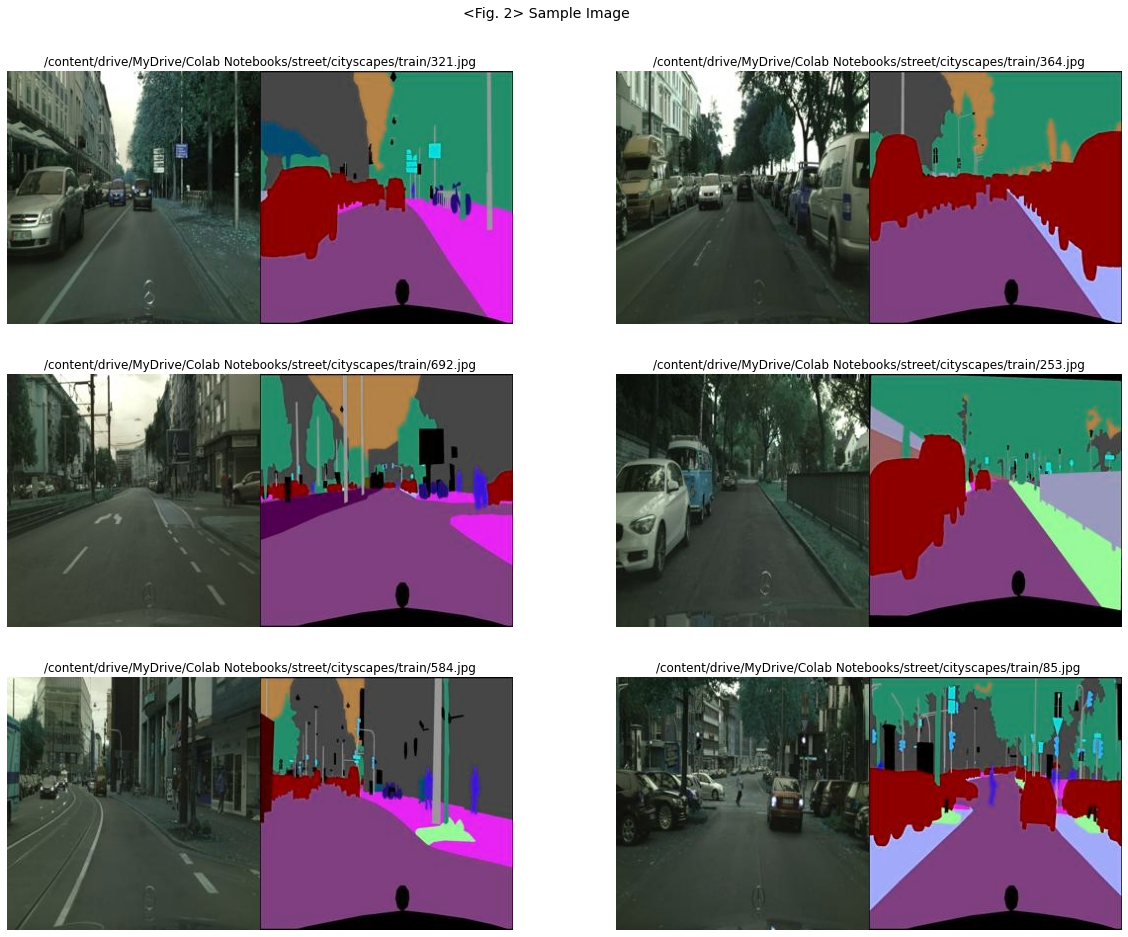

In [ ]:
plt.figure(figsize=(20, 15))
plt.suptitle("<Fig. 2> Sample Image", size=14)
plt.subplots_adjust(top=0.92)
for i in range(1, 7):
    f = train_data_path + os.listdir(train_data_path)[np.random.randint(1000)]
    img = cv2.imread(f, cv2.IMREAD_COLOR)
    plt.subplot(3, 2, i)
    plt.title(f"{f}")
    plt.axis("off")
    plt.imshow(img)
plt.show()

In [ ]:
f = train_data_path + os.listdir(train_data_path)[np.random.randint(1000)]
img = cv2.imread(f, cv2.IMREAD_COLOR)
print(img.shape)

(256, 512, 3)


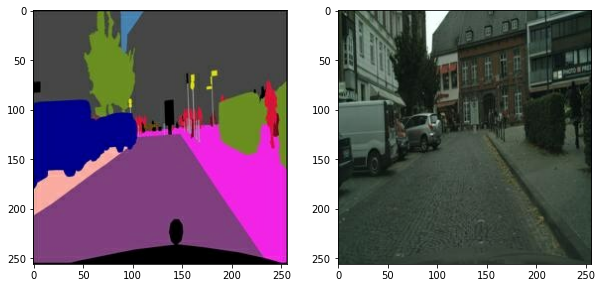

In [ ]:
def normalize(x):
    x = tf.cast(x, tf.float32)
    return (x/127.5) - 1

def denormalize(x):
    x = (x+1)*127.5
    x = x.numpy()
    return x.astype(np.uint8)

def load_img(img_path):
    img = tf.io.read_file(img_path)
    img = tf.image.decode_image(img, 3)
    
    w = tf.shape(img)[1] // 2
    sketch = img[:, :w, :] 
    sketch = tf.cast(sketch, tf.float32)
    colored = img[:, w:, :] 
    colored = tf.cast(colored, tf.float32)
    return normalize(colored), normalize(sketch)


f = train_data_path + os.listdir(train_data_path)[1]
sketch, colored = load_img(f)

plt.figure(figsize=(10,7))
plt.subplot(1,2,1); plt.imshow(denormalize(sketch))
plt.subplot(1,2,2); plt.imshow(denormalize(colored))

In [ ]:
@tf.function() # 빠른 텐서플로 연산을 위해 @tf.function()을 사용합니다. 
def apply_augmentation(sketch, colored):
    stacked = tf.concat([sketch, colored], axis=-1)
    
    _pad = tf.constant([[30,30],[30,30],[0,0]])
    if tf.random.uniform(()) < .5:
        padded = tf.pad(stacked, _pad, "REFLECT")
    else:
        padded = tf.pad(stacked, _pad, "CONSTANT", constant_values=1.)

    out = image.random_crop(padded, size=[256, 256, 6])
    
    out = image.random_flip_left_right(out)
    out = image.random_flip_up_down(out)
    
    if tf.random.uniform(()) < .5:
        degree = tf.random.uniform([], minval=1, maxval=4, dtype=tf.int32)
        out = image.rot90(out, k=degree)
    
    return out[...,:3], out[...,3:]  

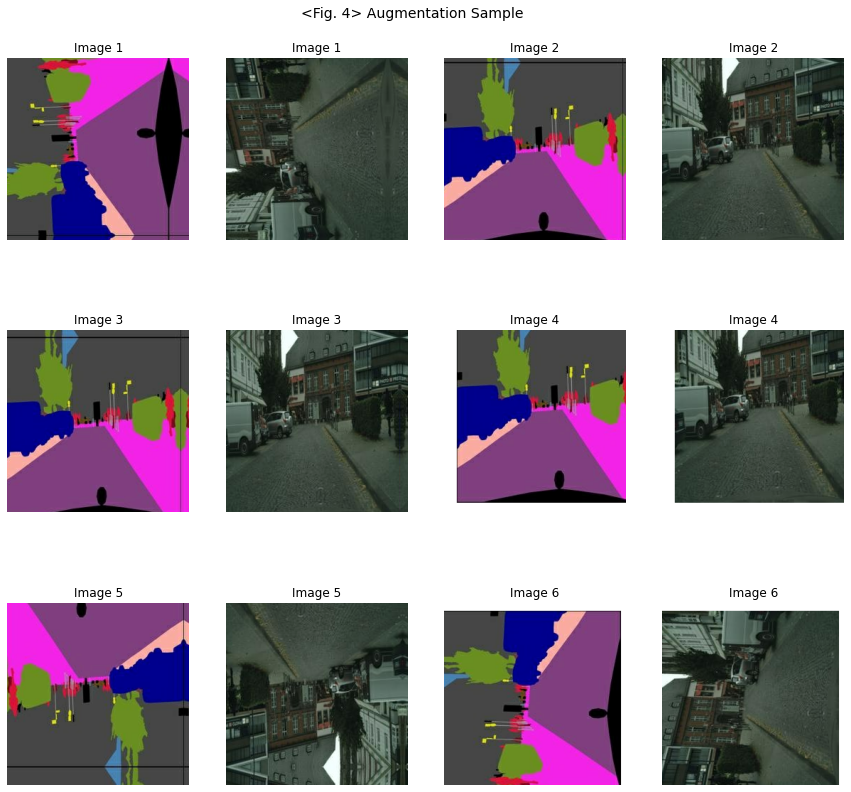

In [ ]:
plt.figure(figsize=(15,13))
plt.suptitle("<Fig. 4> Augmentation Sample", size=14)
plt.subplots_adjust(top=0.95)

img_n = 1
for i in range(1, 13, 2):
    augmented_sketch, augmented_colored = apply_augmentation(sketch, colored)
    
    plt.subplot(3,4,i)
    plt.axis("off")
    plt.imshow(denormalize(augmented_sketch)); plt.title(f"Image {img_n}")
    plt.subplot(3,4,i+1)
    plt.axis("off")
    plt.imshow(denormalize(augmented_colored)); plt.title(f"Image {img_n}")
    img_n += 1
plt.show()

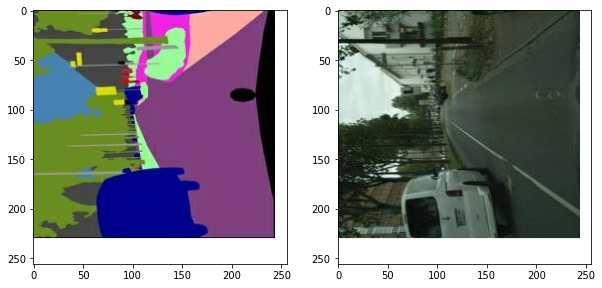

In [ ]:
def get_train(img_path):
    sketch, colored = load_img(img_path)
    sketch, colored = apply_augmentation(sketch, colored)
    return sketch, colored

train_images = data.Dataset.list_files(train_data_path + "*.jpg")
train_images = train_images.map(get_train).shuffle(1000).batch(4)

sample = train_images.take(1)
sample = list(sample.as_numpy_iterator())
sketch, colored = (sample[0][0]+1)*127.5, (sample[0][1]+1)*127.5

plt.figure(figsize=(10,5))
plt.subplot(1,2,1); plt.imshow(sketch[0].astype(np.uint8))
plt.subplot(1,2,2); plt.imshow(colored[0].astype(np.uint8))

## 3. Generator

In [ ]:
class EncodeBlock(layers.Layer):
    def __init__(self, n_filters, use_bn=True):
        super(EncodeBlock, self).__init__()
        self.use_bn = use_bn       
        self.conv = layers.Conv2D(n_filters, 4, 2, "same", use_bias=False)
        self.batchnorm = layers.BatchNormalization()
        self.lrelu = layers.LeakyReLU(0.2)

    def call(self, x):
        x = self.conv(x)
        if self.use_bn:
            x = self.batchnorm(x)
        return self.lrelu(x)

    
class DecodeBlock(layers.Layer):
    def __init__(self, f, dropout=True):
        super(DecodeBlock, self).__init__()
        self.dropout = dropout
        self.Transconv = layers.Conv2DTranspose(f, 4, 2, "same", use_bias=False)
        self.batchnorm = layers.BatchNormalization()
        self.relu = layers.ReLU()
        
    def call(self, x):
        x = self.Transconv(x)
        x = self.batchnorm(x)
        if self.dropout:
            x = layers.Dropout(.5)(x)
        return self.relu(x)
    
    
class DiscBlock(layers.Layer):
    def __init__(self, n_filters, stride=2, custom_pad=False, use_bn=True, act=True):
        super(DiscBlock, self).__init__()
        self.custom_pad = custom_pad
        self.use_bn = use_bn
        self.act = act
        
        if custom_pad:
            self.padding = layers.ZeroPadding2D()
            self.conv = layers.Conv2D(n_filters, 4, stride, "valid", use_bias=False)
        else:
            self.conv = layers.Conv2D(n_filters, 4, stride, "same", use_bias=False)
        
        self.batchnorm = layers.BatchNormalization() if use_bn else None
        self.lrelu = layers.LeakyReLU(0.2) if act else None
        
    def call(self, x):
        if self.custom_pad:
            x = self.padding(x)
            x = self.conv(x)
        else:
            x = self.conv(x)
                
        if self.use_bn:
            x = self.batchnorm(x)
            
        if self.act:
            x = self.lrelu(x)
        return x

In [ ]:
#U-Net Generator 정의

class UNetGenerator(Model):
    def __init__(self):
        super(UNetGenerator, self).__init__()
        encode_filters = [64,128,256,512,512,512,512,512]
        decode_filters = [512,512,512,512,256,128,64]
        
        self.encode_blocks = []
        for i, f in enumerate(encode_filters):
            if i == 0:
                self.encode_blocks.append(EncodeBlock(f, use_bn=False))
            else:
                self.encode_blocks.append(EncodeBlock(f))
        
        self.decode_blocks = []
        for i, f in enumerate(decode_filters):
            if i < 3:
                self.decode_blocks.append(DecodeBlock(f))
            else:
                self.decode_blocks.append(DecodeBlock(f, dropout=False))
        
        self.last_conv = layers.Conv2DTranspose(3, 4, 2, "same", use_bias=False)
    
    def call(self, x):
        features = []
        for block in self.encode_blocks:
            x = block(x)
            features.append(x)
        
        features = features[:-1]
                    
        for block, feat in zip(self.decode_blocks, features[::-1]):
            x = block(x)
            x = layers.Concatenate()([x, feat])
        
        x = self.last_conv(x)
        return x
                
    def get_summary(self, input_shape=(256,256,3)):
        inputs = Input(input_shape)
        return Model(inputs, self.call(inputs)).summary()
    
    
UNetGenerator().get_summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 encode_block (EncodeBlock)     (None, 128, 128, 64  3072        ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 encode_block_1 (EncodeBlock)   (None, 64, 64, 128)  131584      ['encode_block[0][0]']           
                                                                                              

## 3. Disccriminator

In [ ]:
class Discriminator(Model):
    def __init__(self):
        super(Discriminator, self).__init__()
        
        #첫 번째 블록은 단순한 연결(concat)을 수행.
        self.block1 = layers.Concatenate()
        
        self.block2 = DiscBlock(n_filters=64, stride=2, custom_pad=False, use_bn=False, act=True)
        self.block3 = DiscBlock(n_filters=128, stride=2, custom_pad=False, use_bn=True, act=True)
        self.block4 = DiscBlock(n_filters=256, stride=2, custom_pad=False, use_bn=True, act=True)
        self.block5 = DiscBlock(n_filters=512, stride=1, custom_pad=True, use_bn=True, act=True)
        self.block6 = DiscBlock(n_filters=1, stride=1, custom_pad=True, use_bn=False, act=False)
        
        #Discriminator의 최종 출력은 sigmoid 활성화를 사용.
        self.sigmoid = layers.Activation("sigmoid")
        
    
    def call(self, x, y):
        out = self.block1([x, y])
        out = self.block2(out)
        out = self.block3(out)
        out = self.block4(out)
        out = self.block5(out)
        out = self.block6(out)
        return self.sigmoid(out)
    
    def get_summary(self, x_shape=(256,256,3), y_shape=(256,256,3)):
        x, y = Input(x_shape), Input(y_shape) 
        return Model((x, y), self.call(x, y)).summary()
    
Discriminator().get_summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 input_3 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 concatenate_7 (Concatenate)    (None, 256, 256, 6)  0           ['input_2[0][0]',                
                                                                  'input_3[0][0]']          

## 4. Training and Test

In [ ]:
bce = losses.BinaryCrossentropy(from_logits=False)
mae = losses.MeanAbsoluteError()

def get_gene_loss(fake_output, real_output, fake_disc):
    l1_loss = mae(real_output, fake_output)
    gene_loss = bce(tf.ones_like(fake_disc), fake_disc)
    return gene_loss, l1_loss

def get_disc_loss(fake_disc, real_disc):
    return bce(tf.zeros_like(fake_disc), fake_disc) + bce(tf.ones_like(real_disc), real_disc)

In [ ]:
gene_opt = optimizers.Adam(2e-4, beta_1=.5, beta_2=.999)
disc_opt = optimizers.Adam(2e-4, beta_1=.5, beta_2=.999)

In [ ]:
@tf.function
def train_step(sketch, real_colored):
    with tf.GradientTape() as gene_tape, tf.GradientTape() as disc_tape:
        # Generator 예측
        fake_colored = generator(sketch, training=True)
        # Discriminator 예측
        fake_disc = discriminator(sketch, fake_colored, training=True)
        real_disc = discriminator(sketch, real_colored, training=True)
        # Generator 손실 계산
        gene_loss, l1_loss = get_gene_loss(fake_colored, real_colored, fake_disc)
        gene_total_loss = gene_loss + (100 * l1_loss) ## <===== L1 손실 반영 λ=100
        # Discrminator 손실 계산
        disc_loss = get_disc_loss(fake_disc, real_disc)
                
    gene_gradient = gene_tape.gradient(gene_total_loss, generator.trainable_variables)
    disc_gradient = disc_tape.gradient(disc_loss, discriminator.trainable_variables)
    
    gene_opt.apply_gradients(zip(gene_gradient, generator.trainable_variables))
    disc_opt.apply_gradients(zip(disc_gradient, discriminator.trainable_variables))
    return gene_loss, l1_loss, disc_loss

In [ ]:
val_path = [val_data_path + path for path in os.listdir(val_data_path)]

save_images = []
for path in val_path:
    img, _ = load_img(path)
    save_images.append(img)

save_images = np.array(save_images)

def save_val_img(path):
    predict = generator(save_images)
    predict = denormalize(predict)

    plt.figure(figsize=(4, 4))
    plt.subplots_adjust(wspace=0.05, hspace=0.1)
    for i in range(4):
        plt.subplot(2, 2, 1+i)
        plt.imshow(predict[i])
        plt.axis("off")
    plt.savefig(path)
    plt.clf()

In [ ]:
EPOCHS = 500

gen_loss_list, dis_loss_list, L1_loss_list = [], [], []

generator = UNetGenerator()
discriminator = Discriminator()

for epoch in range(1, EPOCHS+1):
    
    if (epoch + 1) % 10 == 0:
        save_val_img(f"/content/drive/MyDrive/Colab Notebooks/street/frame/{epoch}.png")
    
    for i, (sketch, colored) in enumerate(train_images):
        g_loss, l1_loss, d_loss = train_step(sketch, colored)
        
        gen_loss_list.append(g_loss)
        dis_loss_list.append(d_loss)
        L1_loss_list.append(l1_loss)
                
        #손실을 출력
        if (i+1) % 200 == 0 and (epoch + 1) % 50 == 0:
            print(f"EPOCH[{epoch}] - STEP[{i+1}] \
                    \nGenerator_loss:{g_loss.numpy():.4f} \
                    \nL1_loss:{l1_loss.numpy():.4f} \
                    \nDiscriminator_loss:{d_loss.numpy():.4f}", end="\n\n")

EPOCH[49] - STEP[200]                     
Generator_loss:1.7168                     
L1_loss:0.1609                     
Discriminator_loss:1.8296

EPOCH[99] - STEP[200]                     
Generator_loss:2.2494                     
L1_loss:0.1535                     
Discriminator_loss:1.8993

EPOCH[149] - STEP[200]                     
Generator_loss:1.4121                     
L1_loss:0.2260                     
Discriminator_loss:0.3553

EPOCH[199] - STEP[200]                     
Generator_loss:1.5591                     
L1_loss:0.1501                     
Discriminator_loss:1.2211



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  


EPOCH[249] - STEP[200]                     
Generator_loss:2.4828                     
L1_loss:0.1616                     
Discriminator_loss:0.8961

EPOCH[299] - STEP[200]                     
Generator_loss:1.7310                     
L1_loss:0.1663                     
Discriminator_loss:0.2919

EPOCH[349] - STEP[200]                     
Generator_loss:1.4145                     
L1_loss:0.1608                     
Discriminator_loss:0.5152

EPOCH[399] - STEP[200]                     
Generator_loss:1.2734                     
L1_loss:0.1510                     
Discriminator_loss:0.7115

EPOCH[449] - STEP[200]                     
Generator_loss:1.7427                     
L1_loss:0.1944                     
Discriminator_loss:0.6622

EPOCH[499] - STEP[200]                     
Generator_loss:0.7908                     
L1_loss:0.1416                     
Discriminator_loss:0.9827



<Figure size 288x288 with 0 Axes>

<Figure size 288x288 with 0 Axes>

<Figure size 288x288 with 0 Axes>

<Figure size 288x288 with 0 Axes>

<Figure size 288x288 with 0 Axes>

<Figure size 288x288 with 0 Axes>

<Figure size 288x288 with 0 Axes>

<Figure size 288x288 with 0 Axes>

<Figure size 288x288 with 0 Axes>

<Figure size 288x288 with 0 Axes>

<Figure size 288x288 with 0 Axes>

<Figure size 288x288 with 0 Axes>

<Figure size 288x288 with 0 Axes>

<Figure size 288x288 with 0 Axes>

<Figure size 288x288 with 0 Axes>

<Figure size 288x288 with 0 Axes>

<Figure size 288x288 with 0 Axes>

<Figure size 288x288 with 0 Axes>

<Figure size 288x288 with 0 Axes>

<Figure size 288x288 with 0 Axes>

<Figure size 288x288 with 0 Axes>

<Figure size 288x288 with 0 Axes>

<Figure size 288x288 with 0 Axes>

<Figure size 288x288 with 0 Axes>

<Figure size 288x288 with 0 Axes>

<Figure size 288x288 with 0 Axes>

<Figure size 288x288 with 0 Axes>

<Figure size 288x288 with 0 Axes>

<Figure size 288x288 with 0 Axes>

<Figure size 288x288 with 0 Axes>

<Figure size 288x288 with 0 Axes>

<Figure size 288x288 with 0 Axes>

<Figure size 288x288 with 0 Axes>

<Figure size 288x288 with 0 Axes>

<Figure size 288x288 with 0 Axes>

<Figure size 288x288 with 0 Axes>

<Figure size 288x288 with 0 Axes>

<Figure size 288x288 with 0 Axes>

<Figure size 288x288 with 0 Axes>

<Figure size 288x288 with 0 Axes>

<Figure size 288x288 with 0 Axes>

<Figure size 288x288 with 0 Axes>

<Figure size 288x288 with 0 Axes>

<Figure size 288x288 with 0 Axes>

<Figure size 288x288 with 0 Axes>

<Figure size 288x288 with 0 Axes>

<Figure size 288x288 with 0 Axes>

<Figure size 288x288 with 0 Axes>

<Figure size 288x288 with 0 Axes>

<Figure size 288x288 with 0 Axes>

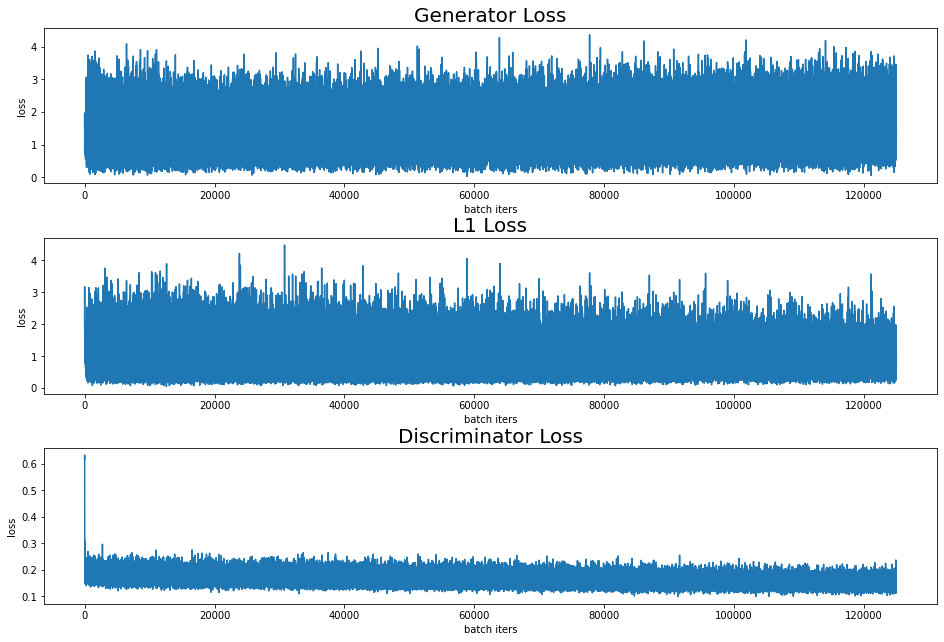

In [ ]:
plt.figure(figsize=(16,10))
plt.subplots_adjust(left=0.125, bottom=0.1,  right=0.9, top=0.9, wspace=0.2, hspace=0.35)

plt.subplot(3, 1, 1)
plt.plot(gen_loss_list)
plt.ylabel('loss')  
plt.xlabel('batch iters')  
plt.title('Generator Loss', fontsize=20)

plt.subplot(3, 1, 2) 
plt.plot(dis_loss_list)
plt.ylabel('loss')  
plt.xlabel('batch iters')  
plt.title('L1 Loss', fontsize=20)

plt.subplot(3, 1, 3)
plt.plot(L1_loss_list)
plt.ylabel('loss')  
plt.xlabel('batch iters')  
plt.title('Discriminator Loss', fontsize=20)

plt.show()

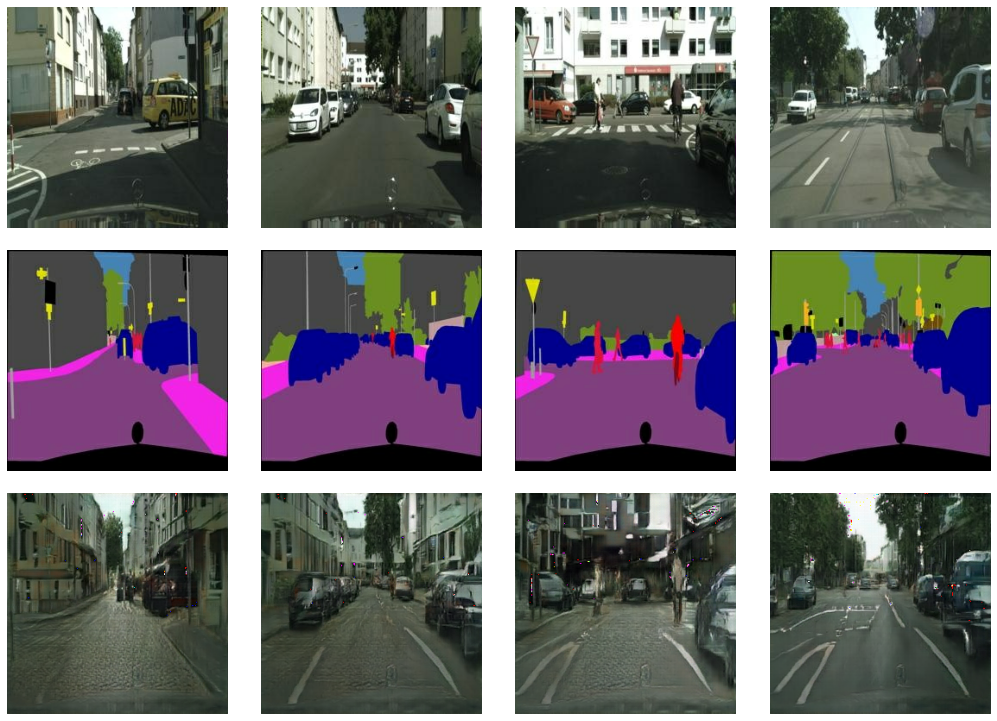

In [ ]:
val_path = [val_data_path + path for path in os.listdir(val_data_path)]

seg_images, real_images = [], []
for path in val_path:
    seg_img, real_img = load_img(path)
    seg_images.append(seg_img)
    real_images.append(real_img)

seg_images = np.array(seg_images)

real_images = np.array(real_images)
real_images = (real_images + 1) * 127.5
real_images = real_images.astype(np.uint8)

predict = generator(seg_images)
predict = denormalize(predict)

seg_images = (seg_images + 1) * 127.5
seg_images = seg_images.astype(np.uint8)

plt.figure(figsize=(18, 13))
plt.subplots_adjust(wspace=0.05, hspace=0.1)
for i in range(4):
    plt.subplot(3, 4, i + 1)
    plt.imshow(real_images[i])
    plt.axis("off")
    
    plt.subplot(3, 4, i + 5)
    plt.imshow(seg_images[i])
    plt.axis("off")
    
    plt.subplot(3, 4, i + 9)
    plt.imshow(predict[i])
    plt.axis("off")

In [ ]:
epoch_nums = [int(path.replace(".png", "")) for path in os.listdir("/content/drive/MyDrive/Colab Notebooks/street/frame/")]
epoch_nums.sort()

img_path_list = [f"/content/drive/MyDrive/Colab Notebooks/street/frame/{epoch}.png" for epoch in epoch_nums]
img_list = [cv2.imread(img_path) for img_path in img_path_list]

imageio.mimsave("/content/drive/MyDrive/Colab Notebooks/street/frame.gif", img_list)

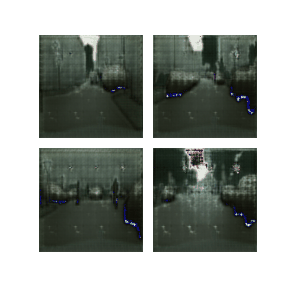

## 5. 회고

1. conditional gan
    - gan과 비슷한 과정을 따라가서 어렵지는 않았다. 채색을 얼추 비슷하게 해가서 신기했다.
    - 학습시간이 오래걸렸지만 epoch을 대폭 향상시키니 좋은 결과를 볼 수가 있었다.

2. gan 원리
    - gan이 돌아가는 원리에대해서는 아직 어렵다. 특히 layer부분이 다양하게 연결되었고 서로 상호작용을 하는데 이 부분이 가장 어려웠다. 지금은 큰 관심은 가지 않지만 훗날 제대로 공부해볼 기회가 있으면 좋을 것 같다.